In [4]:
!pip install -q -r requirements.txt

In [7]:
!pip uninstall -y opencv-python-headless
!pip install opencv-python-headless==4.1.2.30

Found existing installation: opencv-python-headless 4.5.5.64
Uninstalling opencv-python-headless-4.5.5.64:
  Successfully uninstalled opencv-python-headless-4.5.5.64
  Using cached opencv_python_headless-4.1.2.30-cp37-cp37m-manylinux1_x86_64.whl (21.8 MB)


## Data Loading

In [1]:
from os.path import join
import numpy as np 
import torch
import warnings
warnings.filterwarnings('ignore')

In [2]:
DATA_ROOT="./data/"

MRI_root_dir=join(DATA_ROOT,"MRI","MRI_Label")
MRI_anno_file=join(DATA_ROOT,"MRI","annotations/MRI_Label/annotations.json")

CT_root_dir=join(DATA_ROOT,"CT")
CT_anno_file=join(DATA_ROOT,"CT","annotations/annotations.json")

In [3]:
from dataloaders.ctmri_multiclass import CTMRI_MultiClassDataset
import albumentations as A
WIDTH, HEIGHT=256,256

class DivMax(A.ImageOnlyTransform):
    def __init__(self, always_apply=True, p=1.0):
        super().__init__(always_apply, p)
    def apply(self, img, **params):
        img=img/np.max(img)
#         img[img<0.25]=0
#         img[img>0.65]=0
        return img
    
transform = A.Compose([
  A.ToFloat(always_apply=True),
  DivMax(always_apply=True),
  A.Resize(WIDTH, HEIGHT),
  A.HorizontalFlip(p=0.5),
  A.RandomBrightnessContrast(brightness_limit=[-0.05, 0.05], p=0.2),
  A.Rotate((-30, 30), interpolation=0), 
  A.RandomContrast(limit=0.2, p=1),   
])

test_transform = A.Compose([           
  A.ToFloat(always_apply=True),
  DivMax(always_apply=True),
  A.Resize(WIDTH, HEIGHT),
])

In [4]:
ds_kwargs=dict(
    transform=transform,
    test_transform=test_transform,
    test_split=0.2
    )
MRI_ds=CTMRI_MultiClassDataset(MRI_anno_file,MRI_root_dir,**ds_kwargs)
CT_ds=CTMRI_MultiClassDataset(CT_anno_file,CT_root_dir,**ds_kwargs)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [5]:
import torch.utils.data as tud
ldr_kwargs=dict(
    batch_size=8,
    shuffle=True,
    pin_memory=False,
    num_workers=2
)
CT_loader=tud.DataLoader(CT_ds,**ldr_kwargs)
MRI_loader=tud.DataLoader(MRI_ds,**ldr_kwargs)

In [6]:
from dataloaders.ctmri_multiclass import occr_in_ds

MRI_occr=occr_in_ds(MRI_ds)
CT_occr=occr_in_ds(CT_ds)

BATCHSIZE= 3
(3, 256, 256, 3) 
 (3, 256, 256)


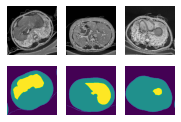

In [7]:
from utils.plotting import show_image_annot
CT_ds.training=True
x,y=next(iter(CT_loader))
show_image_annot(x.numpy().transpose(0,2,3,1),y.numpy(),showPics=3, vmax=CT_ds.n_cats)

In [8]:
set(y.flatten().numpy())

{0, 1, 2}

In [9]:
# from torch import nn

# from models.backbone import UNet
from models.unet import UNet
from models.head import MetricLayer
from models.models import SegModel
# backbone=UNet(decoder_chs=(512, 256, 128)).cuda()
# latent_dims=128

unet_pretrain = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=True).cuda()
backbone=UNet(unet_pretrain).cuda()
latent_dims=32
head_ct=MetricLayer(n_in_features=latent_dims,n_out_features=1+CT_ds.n_cats).cuda()
model_ct=SegModel(backbone,head_ct,(WIDTH, HEIGHT)).cuda()

Using cache found in /home/jovyan/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [10]:
# from torchsummary import summary
# summary(backbone.encoder, (3, 224, 224))

In [11]:
def calc_acc(pred, y):
    correct=(pred.argmax(1)==y).flatten()
    return torch.sum(correct)/len(correct)
def one_batch(i_iter,log,sample_batched,model,criterion,optimizer):
    # Prep input
    x,y=[_.cuda() for _ in sample_batched]
    pred=model(x)
    loss = criterion(pred, y)
    if model.training:
        #Update
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    with torch.no_grad():
        acc=calc_acc(pred, y).item()
        if i_iter==0:
            log['acc'] = acc
        else:
            log['acc'] = (acc+log['acc']*i_iter)/(i_iter + 1)
    # Record
    loss_rec = loss.item()
    log['loss'] = (loss_rec+log['loss']*i_iter)/(i_iter + 1)
    return pred,loss

In [12]:
!mkdir snapshots

mkdir: cannot create directory ‘snapshots’: File exists


In [13]:
from losses.marginal import AddMarginLoss
# w=1/torch.tensor(CT_occr,dtype=torch.float32).cuda()
w=torch.tensor([0.1,0.1,0.8],dtype=torch.float32).cuda()
criterion_ct = AddMarginLoss(ways=1+CT_ds.n_cats,s=10 ,m=1.4,weight=w)
optimizer_ct = torch.optim.SGD(model_ct.parameters(),lr=1e-3,momentum=0.9,weight_decay=0.0005)
# optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
# 
# scheduler = MultiStepLR(optimizer, milestones=[100, 200, 300], gamma=0.1)
# 

In [14]:
from tqdm import tqdm

In [15]:
EPOCH=100
model_ct.train()
best_loss=np.inf
PAITIENCE=5
count=0
try:
    for e in range(EPOCH):
        log= {'epoch':e,'step':0,'loss': 0, 'acc': 0}
        model_ct.train()
        CT_ds.training=True
        session=tqdm(enumerate(CT_loader))
        for i_iter, sample_batched in session:
            pred,loss=one_batch(i_iter,log,sample_batched,model_ct,criterion_ct,optimizer_ct)
            # print loss and take snapshots
            if (i_iter + 1) % 5 == 0:
                log['step']=i_iter+1
                session.set_postfix(log)
        # validate
        if (e + 1) % 2 == 0:
            log = {'epoch':e,'step':'val','loss': 0, 'acc': 0}
            model_ct.eval()
            CT_ds.training=False
            session=tqdm(enumerate(CT_loader))
            with torch.no_grad():
                for i_iter,sample_batched in session:
                    pred,loss=one_batch(i_iter,log,sample_batched,model_ct,criterion_ct,optimizer_ct)
                    if (i_iter + 1) % 5 == 0:
                        session.set_postfix(log)
            # early stop        
            if log["loss"]<best_loss:
                best_loss=log["loss"]
                torch.save(model_ct.state_dict(), 'snapshots/unet_arc_ct_best.pth')
            elif count<=PAITIENCE: count+=1
            else:
                count=0
                best_loss=np.inf
                break 
            
except KeyboardInterrupt:
    print("\nHuman Interrupted")
torch.save(model_ct.state_dict(), 'snapshots/unet_arc_ct_latest.pth')

288it [00:35,  8.21it/s, epoch=0, step=285, loss=5.54, acc=0.892]
288it [00:35,  8.16it/s, epoch=1, step=285, loss=3.33, acc=0.956]
72it [00:03, 18.89it/s, epoch=1, step=val, loss=3.17, acc=0.964]
288it [00:35,  8.11it/s, epoch=2, step=285, loss=3.04, acc=0.967]
288it [00:35,  8.09it/s, epoch=3, step=285, loss=2.93, acc=0.971]
72it [00:03, 18.60it/s, epoch=3, step=val, loss=2.74, acc=0.98] 
288it [00:35,  8.07it/s, epoch=4, step=285, loss=2.82, acc=0.975]
288it [00:35,  8.07it/s, epoch=5, step=285, loss=2.68, acc=0.979]
72it [00:03, 18.84it/s, epoch=5, step=val, loss=2.58, acc=0.985]
288it [00:35,  8.07it/s, epoch=6, step=285, loss=2.61, acc=0.982]
288it [00:35,  8.04it/s, epoch=7, step=285, loss=2.61, acc=0.982]
72it [00:03, 18.19it/s, epoch=7, step=val, loss=2.52, acc=0.986]
288it [00:35,  8.06it/s, epoch=8, step=285, loss=2.56, acc=0.984]
288it [00:35,  8.05it/s, epoch=9, step=285, loss=2.55, acc=0.984]
72it [00:03, 18.85it/s, epoch=9, step=val, loss=2.47, acc=0.986]
288it [00:35,  

In [47]:
model_ct.load_state_dict(torch.load("snapshots/unet_arc_ct_best.pth"))

<All keys matched successfully>

In [16]:
model_ct.eval()
CT_ds.training=False
session=tqdm(enumerate(CT_loader))
with torch.no_grad():
    log = {'epoch':1,'step':'test','loss': 0, 'acc': 0}
    for i_iter,sample_batched in session:
        pred,loss=one_batch(i_iter,log,sample_batched,model_ct,criterion_ct,optimizer_ct)
        session.set_postfix(log)
        break

0it [00:00, ?it/s, epoch=1, step=test, loss=2.42, acc=0.991]


BATCHSIZE= 3
(3, 256, 256) 
 (3, 256, 256)


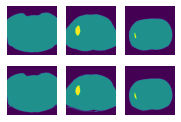

In [17]:
show_image_annot(pred.cpu().detach().argmax(1).numpy(),
                 sample_batched[1].cpu().detach().numpy(),
                 showPics=3, vmax=CT_ds.n_cats)

In [18]:
backbone.train()
backbone.requires_grad_(True)
head_ct.eval()
head_ct.requires_grad_(False)
# backbone.encoder.train()
# backbone.encoder.requires_grad_(True)
# backbone.requires_grad_(False)
# for layer_id,p in enumerate(backbone.parameters()):
#     if layer_id <2:
#         p.requires_grad=True
        
#     else:
#         break

WAYS=1+CT_ds.n_cats
# mri_head=MetricLayer(n_in_features=latent_dims,n_out_features=WAYS).cuda()
model_mri=SegModel(backbone,head_ct,(WIDTH, HEIGHT)).cuda()

w=1/torch.tensor(MRI_occr[:WAYS],dtype=torch.float32).cuda()
# w=torch.tensor([0.1,0.1,0.2,0.2,0.2,0.2],dtype=torch.float32).cuda()
criterion_mri = AddMarginLoss(ways=WAYS,s=10 ,m=1.4,weight=w)
optimizer_mri = torch.optim.SGD(model_mri.parameters(),lr=1e-3,momentum=0.9,weight_decay=0.0005)

In [19]:
from tqdm import tqdm

EPOCH=300
model_mri.train()
best_loss=np.inf
PAITIENCE=5
count=0
try:
    for e in range(EPOCH):
        log= {'epoch':e,'step':0,'loss': 0, 'acc': 0}
        model_mri.train()
        MRI_ds.training=True
        session=tqdm(enumerate(MRI_loader))
        for i_iter, sample_batched in session:
            pred,loss=one_batch(i_iter,log,sample_batched,model_mri,criterion_mri,optimizer_mri)
            # print loss and take snapshots
            if (i_iter + 1) % 5 == 0:
                log['step']=i_iter+1
                session.set_postfix(log)
        # validate
        if (e + 1) % 2 == 0:
            log = {'epoch':e,'step':'val','loss': 0, 'acc': 0}
            model_mri.eval()
            MRI_ds.training=False
            session=tqdm(enumerate(MRI_loader))
            with torch.no_grad():
                for i_iter,sample_batched in session:
                    pred,loss=one_batch(i_iter,log,sample_batched,model_mri,criterion_mri,optimizer_mri)
                    session.set_postfix(log)
                        
            # early stop        
            if log["loss"]<best_loss:
                best_loss=log["loss"]
                torch.save(model_mri.state_dict(), 'snapshots/unet_arc_mri_best.pth')
            elif count<=PAITIENCE: count+=1
            else:
                count=0
                best_loss=np.inf
                break 
            
except KeyboardInterrupt:
    print("\nHuman Interrupted")
torch.save(model_mri.state_dict(), 'snapshots/unet_arc_mri_latest.pth')

16it [00:02,  7.84it/s, epoch=0, step=15, loss=5.74, acc=0.904]
16it [00:02,  7.85it/s, epoch=1, step=15, loss=4.6, acc=0.946] 
4it [00:00, 11.57it/s, epoch=1, step=val, loss=4.54, acc=0.952]
16it [00:01,  8.04it/s, epoch=2, step=15, loss=4.14, acc=0.957]
16it [00:01,  8.02it/s, epoch=3, step=15, loss=4.02, acc=0.959]
4it [00:00, 11.89it/s, epoch=3, step=val, loss=3.98, acc=0.96] 
16it [00:02,  7.96it/s, epoch=4, step=15, loss=3.86, acc=0.964]
16it [00:02,  7.94it/s, epoch=5, step=15, loss=3.78, acc=0.964]
4it [00:00, 12.17it/s, epoch=5, step=val, loss=3.68, acc=0.968]
16it [00:02,  7.96it/s, epoch=6, step=15, loss=3.64, acc=0.964]
16it [00:02,  7.91it/s, epoch=7, step=15, loss=3.56, acc=0.968]
4it [00:00, 12.57it/s, epoch=7, step=val, loss=3.57, acc=0.969]
16it [00:02,  7.82it/s, epoch=8, step=15, loss=3.5, acc=0.97]  
16it [00:02,  7.94it/s, epoch=9, step=15, loss=3.62, acc=0.967]
4it [00:00, 11.34it/s, epoch=9, step=val, loss=3.51, acc=0.968]
16it [00:02,  7.96it/s, epoch=10, step=1

In [20]:
model_mri.load_state_dict(torch.load("snapshots/unet_arc_mri_best.pth"))

<All keys matched successfully>

In [21]:
model_mri.eval()
MRI_ds.training=False
session=tqdm(enumerate(MRI_loader))
with torch.no_grad():
    for i_iter,sample_batched in session:
        pred,loss=one_batch(i_iter,log,sample_batched,model_mri,criterion_mri,optimizer_mri)
        session.set_postfix(log)
        break

0it [00:00, ?it/s, epoch=35, step=val, loss=3.06, acc=0.98]


BATCHSIZE= 8
(8, 256, 256) 
 (8, 256, 256)


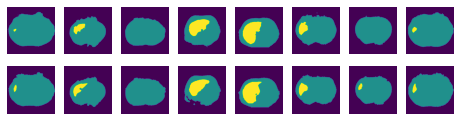

In [22]:
show_image_annot((pred.cpu().detach().argmax(1)).numpy(),
# show_image_annot((pred.cpu().detach().argmax(1)).numpy(),
                 (sample_batched[1]).cpu().detach().numpy(),
                 showPics=8, vmax=2)

In [57]:
set(sample_batched[1].flatten().numpy())

{0, 1, 2}

In [89]:
ds_kwargs=dict(
    transform=transform,
    test_transform=None,
    test_split=None
    )
MRI_ds=CTMRI_MultiClassDataset(MRI_anno_file,MRI_root_dir,**ds_kwargs)
MRI_loader=tud.DataLoader(MRI_ds,**ldr_kwargs)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [92]:
model_mri.train()
MRI_ds.training=True
for e in range(3):
    log= {'epoch':e,'step':0,'loss': 0, 'acc': 0}
    session=tqdm(enumerate(MRI_loader))
    for i_iter, sample_batched in session:
        pred,loss=one_batch(i_iter,log,sample_batched,model_mri,criterion_mri,optimizer_mri)
        # print loss and take snapshots
        if (i_iter + 1) % 5 == 0:
            log['step']=i_iter+1
            session.set_postfix(log)

20it [00:02,  7.50it/s, epoch=0, step=20, loss=3.26, acc=0.96] 
20it [00:02,  7.63it/s, epoch=1, step=20, loss=3.24, acc=0.96] 
20it [00:02,  7.64it/s, epoch=2, step=20, loss=3.33, acc=0.963]


In [96]:
from dataloaders.ctmri_multiclass import CTMRI_InferenceDataset
ds_kwargs=dict(
    transform=test_transform,
    test_split=None
    )
ldr_kwargs=dict(
    batch_size=8,
    shuffle=False,
    pin_memory=False,
    num_workers=2
)
test_root_dir=join(DATA_ROOT,"testset")
test_anno_file=join(DATA_ROOT,"testset","annotations/annotations_gt.json")
test_ds=CTMRI_MultiClassDataset(test_anno_file,test_root_dir,**ds_kwargs)
# test_ds=CTMRI_InferenceDataset(test_anno_file,test_root_dir,test_transform=test_transform)
test_loader=tud.DataLoader(test_ds,**ldr_kwargs)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [97]:
model_mri.eval()
test_ds.training=True
session=tqdm(enumerate(test_loader))
with torch.no_grad():
    for i_iter,sample_batched in session:
        pred,loss=one_batch(i_iter,log,sample_batched,model_mri,criterion_mri,optimizer_mri)
        session.set_postfix(log)
        break

0it [00:00, ?it/s, epoch=2, step=20, loss=8.66, acc=0.732]


In [98]:
test_ds=CTMRI_InferenceDataset(test_anno_file,test_root_dir,test_transform=test_transform)
test_loader=tud.DataLoader(test_ds,**ldr_kwargs)
model_mri.eval()
pred=[]
with torch.no_grad():
    for xx in test_loader:
        pred.append(model_mri(xx.cuda()))
pred=torch.cat(pred)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [99]:
predictions=pred.cpu().detach().numpy()

In [100]:
np.savez("prediction.npz",predictions)

In [101]:
def mask2rle(img):
    """
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formatted
    """
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
output=[*map(mask2rle,(predictions.argmax(1)==2).astype("int8"))]
# output=[*map(mask2rle,(predictions[:,2]>0.5).astype("int8"))]

In [102]:
import pandas as pd
df=pd.read_csv("sample_submission.csv")
df["rle"]=output
df.to_csv("submission_pretrain_argmax.csv",index=False)